## Analyzing warbler data from Alcaide et al 2014

We want to be able to recapitulate the ring-like migration surface of the greenish warbler species in Asia, but also detect long-range migration events from the SpaceMix paper. 

In [750]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import numpy as np
from datetime import date
import pkg_resources
from sklearn.impute import SimpleImputer
from pandas_plink import read_plink
from copy import deepcopy
import itertools as it
import statsmodels.api as sm
from scipy.stats.distributions import chi2
from random import choices
import scipy as sp
import networkx as nx

# viz
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import seaborn as sns
import plotly.express as px

# feems
import sys
sys.path.append('../../')
from feems.utils import prepare_graph_inputs
from feems.spatial_graph import query_node_attributes
from feems import SpatialGraph, Viz, Objective
from feems.cross_validation import run_cv, comp_mats, run_cv_joint
from feems.helper_funcs import cov_to_dist, comp_genetic_vs_fitted_distance, plot_default_vs_long_range, get_best_lre
from feems.joint_ver import Joint_SpatialGraph, Joint_Objective

# change matplotlib fonts
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [72]:
os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/warblers/data")
coord = np.loadtxt("warblr.coord")  # sample coordinates
outer = np.loadtxt("warblr_spc.outer")  # outer coordinates
grid_path = "/Users/vivaswatshastry/src/feems/feems/data/grid_100.shp"  # path to discrete global grid

# # graph input files
outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
                                             ggrid=grid_path,
                                             translated=False, 
                                             buffer=3,
                                             outer=outer)
genotypes = np.loadtxt('genotypes_ESM13.csv',skiprows=0,delimiter=' ')

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)


In [69]:
# genotypeswoTU = genotypes[np.concatenate((range(34),range(36,genotypes.shape[0]))),:]
# genotypeswoTU = np.delete(genotypeswoTU,np.where(genotypeswoTU.sum(axis=0)==0)[0],1)
# genotypeswoTU = np.delete(genotypeswoTU,np.where(genotypeswoTU.sum(axis=0)==2*genotypeswoTU.shape[0])[0],1)

In [89]:
# os.chdir("/Users/vivaswatshastry/Google Drive/Other computers/My Mac mini/Documents/feemsResults/59-Ursus_Example")
# coord = np.loadtxt("59-Ursus_FILT.coords.txt",usecols=(1,2))  # sample coordinates
# outer = np.loadtxt("california_grid.txt")  # outer coordinates
# grid_path = "world_triangle_res8.shp"  # path to discrete global grid

# (bim, fam, G) = read_plink("59-Ursus_pruned_0.6")
# imp = SimpleImputer(missing_values=np.nan, strategy="mean")
# genotypes = imp.fit_transform((np.array(G)).T)

# print("n_samples={}, n_snps={}".format(genotypes.shape[0], genotypes.shape[1]))

# # graph input files
# outer, edges, grid, _ = prepare_graph_inputs(coord=coord, 
#                                              ggrid=grid_path,
#                                              translated=True, 
#                                              buffer=3,
#                                              outer=None)

# genotypes = genotypes[:,np.random.choice(genotypes.shape[1],size=200000,replace=False)]
# genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==0)[0],1)
# genotypes = np.delete(genotypes,np.where(genotypes.sum(axis=0)==2*genotypes.shape[0])[0],1)

In [705]:
# warblr_graph = Joint_SpatialGraph(genotypeswoTU, coord[np.concatenate((range(34),range(36,genotypes.shape[0]))),:], grid, edges)
# warblr_graph.fit(lamb=0.5,optimize_q='n-dim')

# smgraph = SpatialGraph(genotypes, coord, grid, edges)
smgraph.fit(lamb=1.); smgraph.s2
# smgraph.fit(lamb=.75,optimize_q='n-dim',lamb_q=.25,alpha_q=.5)

# obj = Joint_Objective(warblr_graph); obj.inv(); obj.grad(reg=False)
# fit_cov, _, emp_cov = comp_mats(obj)
# fit_dist = cov_to_dist(fit_cov)[np.tril_indices(warblr_graph.n_observed_nodes, k=-1)]
# emp_dist = cov_to_dist(emp_cov)[np.tril_indices(warblr_graph.n_observed_nodes, k=-1)]
# X = sm.add_constant(fit_dist)
# mod = sm.OLS(emp_dist, X)
# res = mod.fit()
# muhat, betahat = res.params
# plt.plot(fit_dist, emp_dist, 'o', color='grey', alpha=0.5, markersize=4); plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1)
# plt.text(1, 0.3, r'$R^2 \approx {}$'.format(np.around(res.rsquared_adj,2)), fontsize=15); plt.title(r'$c=0.25$'); plt.xlabel('fit distance'); plt.ylabel('empirical distance'); plt.grid();

# het_white(res.resid, X)

# plt.hist(emp_dist/fit_dist-np.mean(emp_dist/fit_dist),bins=15); plt.axvline(-1.7*np.std(emp_dist/fit_dist),color='red')
# plt.plot(fit_dist,emp_dist/fit_dist-np.mean(emp_dist/fit_dist),'ko',alpha=0.8); plt.axhline(-2.1*np.std(emp_dist/fit_dist),color='red',ls='--'); plt.axhline(0,color='grey',linewidth=2); plt.grid()
# for k in np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist)< -2 * np.std(emp_dist/fit_dist))[0]:
#     x = np.floor(np.sqrt(2*k+0.25)-0.5).astype('int')+1; y = int(k - 0.5*x*(x-1)); print(x, y)

# sp.stats.norm.ppf(0.01)

# np.where(emp_dist/fit_dist-np.mean(emp_dist/fit_dist) < -2 * np.std(emp_dist/fit_dist))[0]
# pvals = sp.stats.norm.cdf((emp_dist/fit_dist-np.mean(emp_dist/fit_dist)), 0, np.std(emp_dist/fit_dist))
# np.where(pvals < 0.01)[0]

# idx = np.random.choice(genotypes.shape[1],size=1500,replace=False)
# bootgenotypes = genotypes[:,idx]
# bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
# bootgenotypes = np.delete(bootgenotypes,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
# warblr_graph = Joint_SpatialGraph(genotypes, coord, grid, edges)
# warblr_graph.fit(lamb=.5,optimize_q='n-dim',lamb_q=1.,alpha_q=0.1)

constant-w/variance fit, converged in 120 iterations, train_loss=46442.9086245
lambda=1.00000, alpha=1.96629, beta=0.00000, converged in 503 iterations, train_loss=37713.16918


0.9954018536841882

[2343, 23]

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


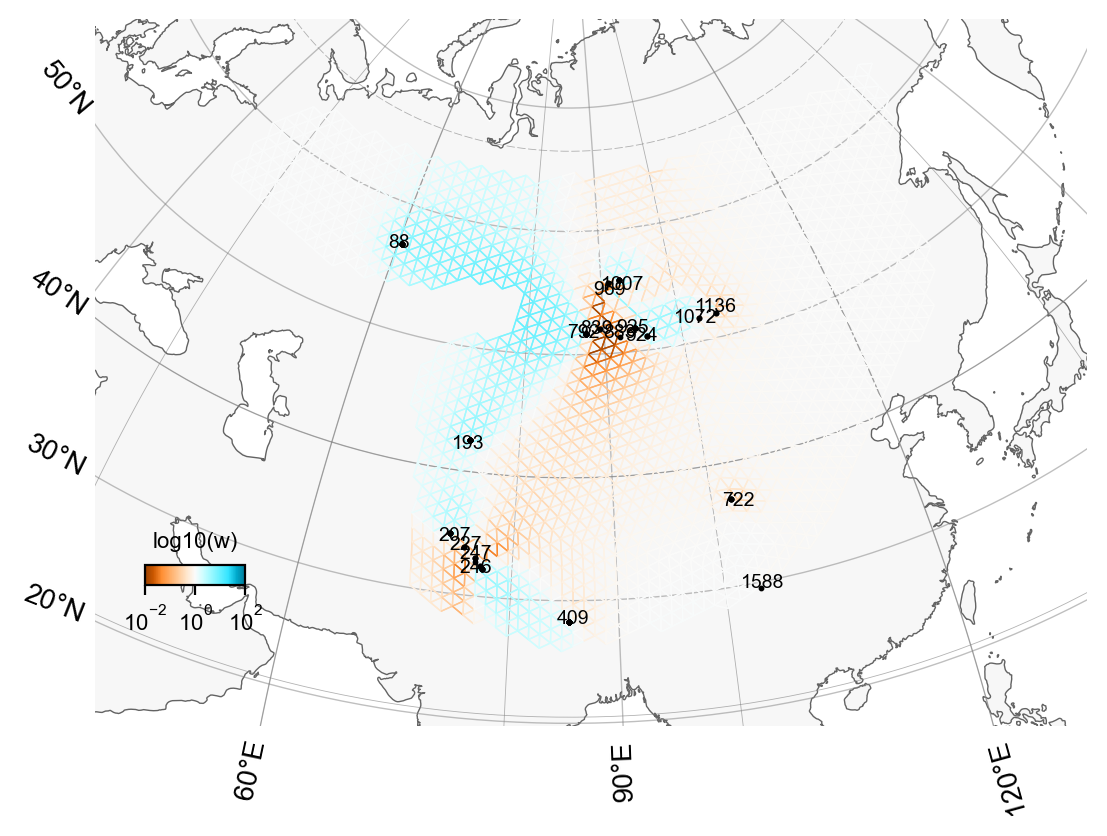

In [361]:
projection = ccrs.AzimuthalEquidistant(central_longitude=85.5, central_latitude=42.54)   
fig = plt.figure(dpi=200)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=10, 
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8, cbar_width=0.5, cbar_height=0.1,
        cbar_font_size=8)
v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
v.draw_map(); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=True); v.draw_edge_colorbar()

In [757]:
# lle, te = get_best_lre(warblr_graph, lamb_cv=0.1, k=5, top=10, nchoose=100, option='hard')
# import cProfile
# import re

warblr_graph.fit(lamb=1.,optimize_q=None)
# warblr_graph.s2
# wn = warblr_graph.w

# plt.scatter(wn,warblr_graph.w,alpha=0.5); plt.grid(); plt.axline((1,1),slope=1)

# warblr_graph.fit(lamb=10.5,optimize_q='n-dim',lamb_q=1.,alpha_q=0.5,option='onlyc',long_range_edges=[(2,15),(13,16),(7,18),(0,10)])
# warblr_graph.c 
# obj = Joint_Objective(warblr_graph); obj.inv(); obj.grad(reg=False)
# obj.Linv.shape

AssertionError: lambda must be float

In [51]:
def get_FEEMS_demes_nll_w_c(c, sp_graph, obj, lrn, form='element'):
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T
    
    o = sp_graph.n_observed_nodes

    Rmat = -2*obj.Linv[:o,:o] + np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:o,:o]),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)       

    if(form!='matrix'):
        ##-----------------using the element-wise formulation----------------------##
        ## sd
        ## resmat[lrn[0][0],lrn[0][1]] = (2*c**2-6*c+4)*Rmat[lrn[0][0],lrn[0][1]] + (c**2-6*c+3)/sp_graph.q[lrn[0][0]] + (c**2+3)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][0],lrn[0][1]] = (0.5*c**2-1.5*c+1)*Rmat[lrn[0][0],lrn[0][1]] + (1+c)/sp_graph.q[lrn[0][0]] + (1-c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],lrn[0][0]] = resmat[lrn[0][0],lrn[0][1]]

        ## id
        for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]):
            resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Rmat[i,lrn[0][0]] + 0.5*(c**2-c)*Rmat[lrn[0][0],lrn[0][1]] + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[lrn[0][0]]
            resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    else:
        ##-----------------using the matrix formulation----------------------##
        BR1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); BR2 = np.zeros_like(BR1); BR3 = np.zeros_like(BR1);

        ## sd
        BR1[lrn[0][0],lrn[0][1]] = 0.5*c**2-1.5*c+1
        BR1[lrn[0][1],lrn[0][0]] = BR1[lrn[0][0],lrn[0][1]]
        ## id
        for i in set(range(BR1.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            #id
            BR1[i,lrn[0][1]] = 1-c
            BR1[lrn[0][1],i] = BR1[i,lrn[0][1]]
            # sd
            BR2[i,lrn[0][1]] = c
            BR2[lrn[0][1],i] = BR2[i,lrn[0][1]]
            # is
            BR3[i,lrn[0][1]] = 0.5*(c**2-c)
            BR3[lrn[0][1],i] = BR3[i,lrn[0][1]]

        BQ1 = np.ones((sp_graph.n_observed_nodes,sp_graph.n_observed_nodes)); 

        BQ1[lrn[0][0],lrn[0][1]] = 1+c
        BQ1[lrn[0][1],lrn[0][0]] = 1-c

        Rismat = np.zeros_like(Rmat); Rsdmat = np.zeros_like(Rmat); Qismat = np.zeros_like(Rmat); Qidmat = np.zeros_like(Rmat)
        for i in set(range(Rmat.shape[0]))-set([lrn[0][0],lrn[0][1]]):
            Rismat[i,lrn[0][1]] = Rmat[i,lrn[0][0]]
            Rismat[lrn[0][1],i] = Rismat[i,lrn[0][1]]

            Rsdmat[i,lrn[0][1]] = Rmat[lrn[0][0],lrn[0][1]]
            Rsdmat[lrn[0][1],i] = Rsdmat[i,lrn[0][1]]

            Qismat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][0]]
            Qismat[lrn[0][1],i] = Qismat[i,lrn[0][1]]

            Qidmat[i,lrn[0][1]] = 1/sp_graph.q[lrn[0][1]]
            Qidmat[lrn[0][1],i] = Qidmat[i,lrn[0][1]]

        resmat = np.multiply(BR1,Rmat) + np.multiply(BR3,Rsdmat) + np.multiply(BQ1,Q1mat) + np.multiply(Q1mat.T,BQ1.T) + np.multiply(BR2,Rismat+Qismat-Qidmat) - 2*np.diag(1/sp_graph.q)

    # return resmat
    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

def get_FEEMS_udemes_nll_w_c(c, sp_graph, obj, lrn, Lpinv):
    '''Here, we are modeling the admixture est. framework between an unsampled deme (1) & a sampled deme (d)'''
    # sp_graph = opts['sp_graph']; obj = opts['obj']; lrn = opts['lrn'] # (1, d, s)
    C = np.vstack((-np.ones(sp_graph.n_observed_nodes-1),np.eye(sp_graph.n_observed_nodes-1))).T

    Rmat = -2*obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes] + np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1)).T @ np.ones((sp_graph.n_observed_nodes,1)).T + np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv[:sp_graph.n_observed_nodes,:sp_graph.n_observed_nodes]),(1,-1))
    Q1mat = (np.ones((sp_graph.n_observed_nodes,1)) @ np.reshape(1/sp_graph.q,(1,-1))).T
    resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/sp_graph.q)      

    neighs = list(sp_graph.neighbors(nx.get_node_attributes(sp_graph,'permuted_idx')[lrn[0][0]]))
    ## only for sampled neighboring nodes 
    neighs = [s for s in neighs if nx.get_node_attributes(sp_graph,'n_samples')[s]>0]

    R1d = -2*Lpinv[lrn[0][0],lrn[0][1]] + Lpinv[lrn[0][0],lrn[0][0]] + Lpinv[lrn[0][1],lrn[0][1]]

    for s in neighs:
        # convert back to appropriate indexing excluding the unsampled demes
        s = [k for k, v in nx.get_node_attributes(sp_graph,'permuted_idx').items() if v==s][0]
        resmat[s,lrn[0][1]] = Rmat[s,lrn[0][1]] + 0.5*(c**2-c)*R1d + (1-c)/sp_graph.q[s] + (1+c)/sp_graph.q[lrn[0][1]]
        resmat[lrn[0][1],s] = resmat[s,lrn[0][1]]

    # closest sampled deme is the proxy source for the unsampled deme
    proxs = np.argmin([nx.shortest_path_length(sp_graph,source=lrn[0][0],target=d) for d in set([k for k, v in nx.get_node_attributes(sp_graph,'n_samples').items() if v>0])-set([lrn[0][0]])])
    ## id
    for i in set(range(sp_graph.n_observed_nodes))-set([lrn[0][0],lrn[0][1]]+neighs):
        Ri1 = -2*Lpinv[i,lrn[0][0]] + Lpinv[i,i] + Lpinv[lrn[0][0],lrn[0][0]]
        resmat[i,lrn[0][1]] = (1-c)*(Rmat[i,lrn[0][1]]) + c*Ri1 + 0.5*(c**2-c)*R1d + 1/sp_graph.q[i] + (1-c)/sp_graph.q[lrn[0][1]] + c/sp_graph.q[proxs]
        resmat[lrn[0][1],i] = resmat[i,lrn[0][1]]

    return -sp.stats.wishart.logpdf(2*C @ sp_graph.S @ C.T, sp_graph.n_snps, -0.5/sp_graph.n_snps*C @ resmat @ C.T)

In [417]:
# obj.Linv.shape
# af = genotypes.sum(axis=0)/(2*95)
# plt.hist(af,bins=20); plt.xlabel('allele frequency'); 
# plt.plot(2*af*(1-af),'ko',alpha=0.4); plt.grid()

# TU: 34, 35 & AB: 8, 9 (~60% of sites are invariant between the two)
# p1 = genotypes[34:36,:].sum(axis=0)/(2*2)
# p2 = genotypes[76:78,:].sum(axis=0)/(2*2)

# fst = (p1*(1-p2-1+p1) + p2*(1-p1-1+p2))/(p1*(1-p2)+p2*(1-p1))
## fst[np.isnan(fst)] = 0
# plt.plot(fst[~np.isnan(fst)],'k-o',alpha=0.3); plt.grid(); plt.ylabel(r'$F_{ST}$'); plt.xlabel('SNP index')
# nx.get_node_attributes(warblr_graph,'permuted_idx')
Lpinv = sp.sparse.linalg.pinv(warblr_graph.L); 
# obj = Joint_Objective(warblr_graph); obj.inv(); obj.grad(reg=False)

AttributeError: module 'scipy.sparse.linalg' has no attribute 'pinv'

In [644]:
# randedge = [(x,14) for x in list(set(range(1000))-set([14]))]
## only pick non-edge demes to avoid boundary issues 
# randedge = list(it.compress(randedge,np.array([sum(1 for _ in warblr_graph.neighbors(nx.get_node_attributes(warblr_graph,'permuted_idx')[i])) for i in list(set(range(1200))-set([14]))])==6))
# randedge = [(x,15) for x in [list(nx.get_node_attributes(warblr_graph, 'permuted_idx').values()).index(n) for n in np.unique(neighs)]] 
# isc2 = np.zeros(len(randedge)); llc2 = np.zeros(len(randedge))
randedge, isc2, llc2 = calc_contour(obj, destpid=1072, sourcepid=88, coverage='radius', radius=5)
# for ie, e in enumerate(randedge):
#     if e[0]<18:
#         res = sp.optimize.minimize_scalar(get_FEEMS_demes_nll_w_c, args=(warblr_graph, obj, [e]), bounds=(0,1), method='bounded')
#         isc2[ie] = res.x; llc2[ie] = res.fun
#     else:
#         try:
#             res = sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(warblr_graph, obj, [e], Lpinv), bounds=(0,1), method='bounded')
#         except:
#             continue
#         isc2[ie] = res.x; llc2[ie] = res.fun

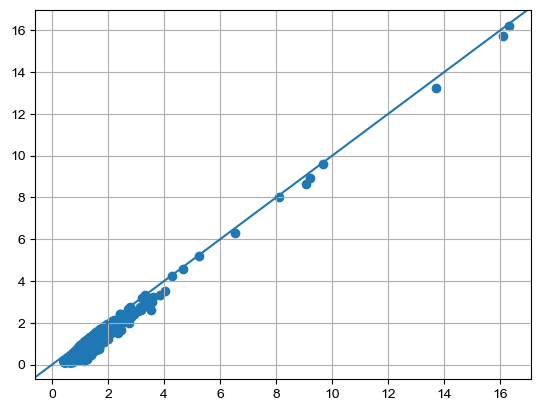

In [110]:
# sp.optimize.minimize_scalar(get_FEEMS_udemes_nll_w_c, args=(warblr_graph, objf, [(555,15)], Lpinv), bounds=(0,1), method='bounded')
# isc2[llc2-20<np.min(llc2)]
# warblr_graph.w.shape,len(list(warblr_graph.edges))
# Lpinv = np.linalg.pinv(warblr_graph.L.todense());
# fac = cholmod.cholesky(sp.sparse.csc_matrix(warblr_graph.L_block['dd']+np.ones((1571,1571))/1589))
plt.scatter(np.diag(Lpinv)[18:],np.linalg.norm(fac.solve_L(np.diag(np.repeat(1,1571)),use_LDLt_decomposition=False),axis=0)**2); plt.axline((0.2,0.2),(1,1)); plt.grid()
# plt.plot(np.linalg.norm(fac.solve_L(np.diag(np.repeat(1,1571)),use_LDLt_decomposition=False),axis=0)**2)

In [242]:
permuted_idx = query_node_attributes(warblr_graph, "permuted_idx")
# obs_perm_ids = permuted_idx[: warblr_graph.n_observed_nodes]
# node_to_pop = pd.DataFrame(index = np.arange(warblr_graph.n_observed_nodes), columns = ['nodes', 'pops'])
# node_to_pop['nodes'] = obs_perm_ids

# max_res_nodes = [(2,15)] #[(1,9),(2,15),(16,13),(0,10)] #[(10,1),(2,15),(0,13),(7,18)]
# [(255, 1060), (484, 1195), (1224, 1146), (12, 1092)] #[(1092, 255), (484, 1195), (12, 1146), (1264, 700)]
# list(map(tuple,node_to_pop['nodes'][np.ravel(max_res_nodes)].values.reshape(1,2)))

# C = np.vstack((-np.ones(warblr_graph.n_observed_nodes-1),np.eye(warblr_graph.n_observed_nodes-1))).T
# bootgenotypesc = genotypes[:,list(set(range(2247))-set(idx))]
# bootgenotypesc = np.delete(bootgenotypesc,np.where(bootgenotypes.sum(axis=0)==0)[0],1)
# bootgenotypesc = np.delete(bootgenotypesc,np.where(bootgenotypes.sum(axis=0)==2*bootgenotypes.shape[0])[0],1)
# warblr_graphc = Joint_SpatialGraph(bootgenotypesc, coord, grid, edges)
# warblr_graphc.fit(lamb=1.,optimize_q='n-dim',lamb_q=1.,alpha_q=0.5)
# obj = Joint_Objective(warblr_graphc); obj.inv(); obj.grad(reg=False);
# Rmat = -2*obj.Linv[:19,:19] + np.reshape(np.diag(obj.Linv),(1,-1)).T @ np.ones((warblr_graphc.n_observed_nodes,1)).T + np.ones((warblr_graphc.n_observed_nodes,1)) @ np.reshape(np.diag(obj.Linv),(1,-1))
# Q1mat = (np.ones((warblr_graphc.n_observed_nodes,1)) @ np.reshape(1/warblr_graphc.q,(1,-1))).T
# resmat = Rmat + (Q1mat + Q1mat.T) - 2*np.diag(1/warblr_graphc.q)
# llnull = sp.stats.wishart.logpdf(2*C @ warblr_graphc.S @ C.T, warblr_graphc.n_snps, -0.5/warblr_graphc.n_snps*C @ resmat @ C.T)

# warblr_graph.fit(lamb=1.,optimize_q='n-dim',lamb_q=1.,alpha_q=0.5, option='onlyc', long_range_edges=[(1,9)])
# warblr_graph.c # array([0.46752871, 0.1849542 , 0.42977615, 0.38951518]) # array([0.08894425, 0.25479647, 0.12617096, 0.05590574])
# objc = Joint_Objective(warblr_graphc); objc.inv(); objc.grad(reg=False); print(sp.stats.chi2.sf(-2*(llnull+objc.neg_log_lik_c(warblr_graphc.c)),2))
# [list(warblr_graph.neighbors(n1)) for n1 in list(warblr_graph.neighbors(n)) for n in list(warblr_graph.neighbors(484))]
# neighs = [] 
# for n in list(warblr_graph.neighbors(484)):
#     n1 = list(warblr_graph.neighbors(n))
#     for n2 in n1:
#         n3 = list(warblr_graph.neighbors(n2))
#         for n4 in n3:
#             n5 = list(warblr_graph.neighbors(n4))
#             for n6 in n5:
#                 neighs.append(list(warblr_graph.neighbors(n6)))

# neighs = []
# neighs = list(warblr_graph.neighbors(484))
# for r in range(7):
#     tempn = [list(warblr_graph.neighbors(n1)) for n1 in neighs]
#     neighs = np.unique(list(it.chain(*tempn)))
# permuted_idx[randedge[np.argmin(llc2)][0]], permuted_idx[14], isc2[np.where(llc2-2<np.min(llc2)+2)[0]]
# np.where(llc2-2<np.min(llc2))

In [649]:
# np.unique(neighs)
# [warblr_graph.neighbors(nn) for nn in n]
# np.ravel([list(warblr_graph.neighbors(n1)) for n1 in n])
# sprange = [[60,80],[20,40]]
# randedge = []
# for n in range(warblr_graph.number_of_nodes()):
#     if warblr_graph.nodes[n]['pos'][0] > sprange[0][0] and warblr_graph.nodes[n]['pos'][0] < sprange[0][1]:
#                 if warblr_graph.nodes[n]['pos'][1] > sprange[1][0] and warblr_graph.nodes[n]['pos'][1] < sprange[1][1]:
#                     randedge.append((n,14))

15

In [663]:
nx.get_node_attributes(obj.sp_graph,'permuted_idx')[randedge[np.argmin(llc2)][0]]

88

/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/set_operations.py:133: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/Users/vivaswatshastry/mambaforge/envs/feems/lib/python3.10/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(


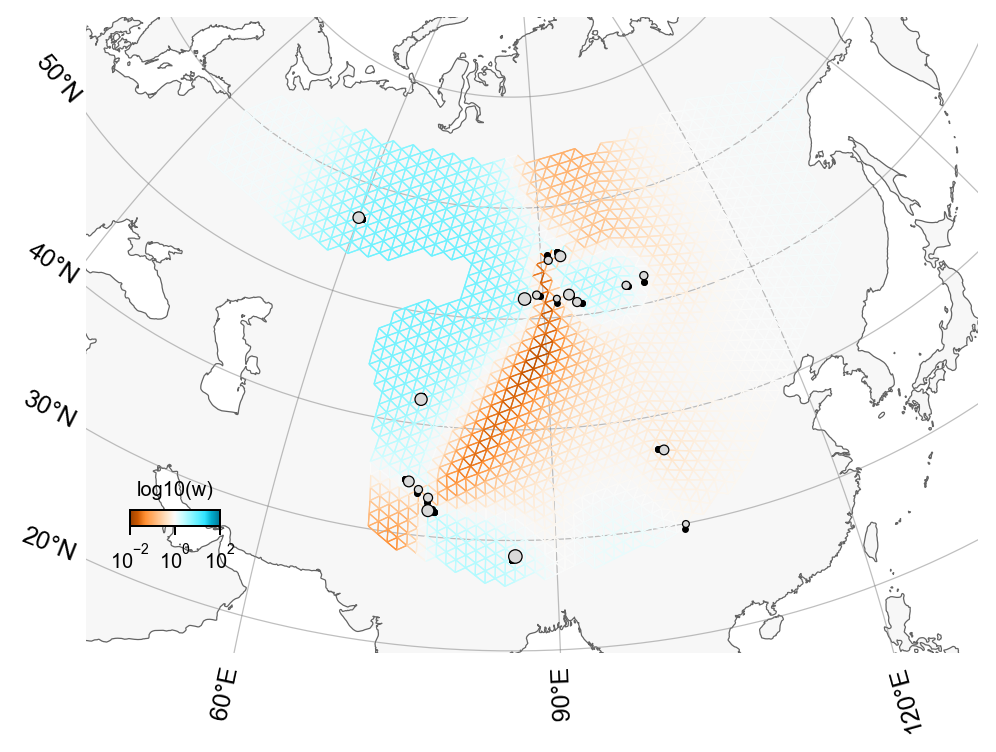

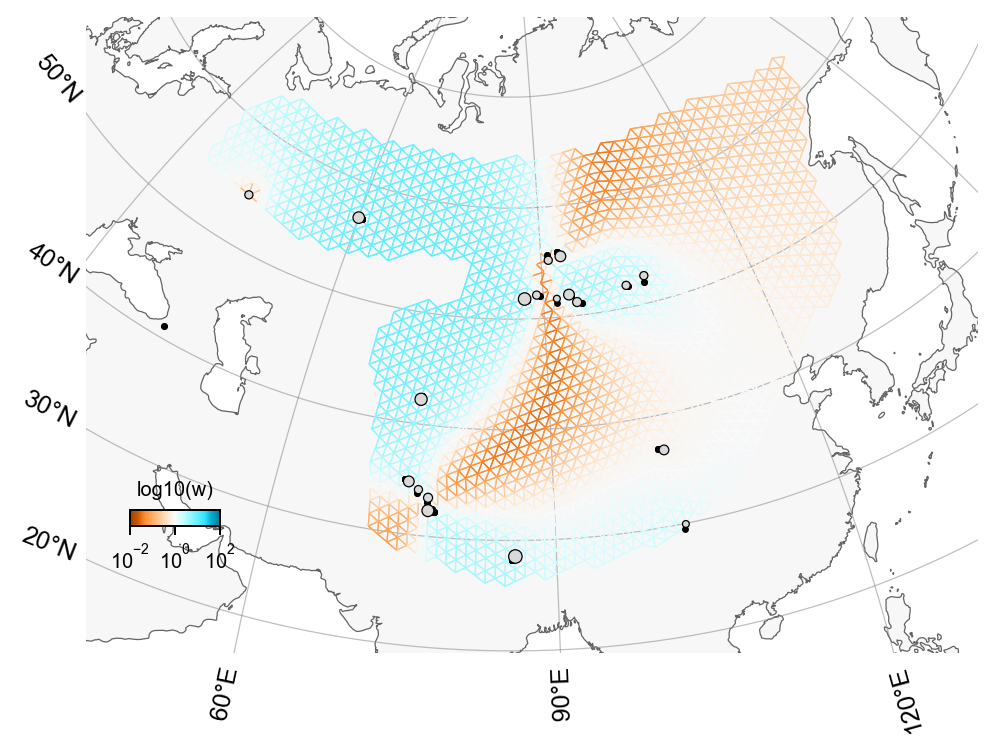

In [737]:
# fig = plt.figure(dpi=180)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
#         cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
# v.draw_map(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,extend='min',cmap='Greys',vmax=1,vmin=0,alpha=0.8,levels=5); 
# CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],isc2,cmap='Greys',extend='min',vmax=1,vmin=0,alpha=0.8,levels=5); ax.clabel(CS, inline=1, fontsize=8, colors='k')

## basically ignore demes with log-lik units less than 100 of max
# fig = plt.figure(dpi=180)
# ax = fig.add_subplot(1, 1, 1, projection=projection)  
# v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
#         edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
#         obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
#         cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
# v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
# v.draw_map(); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.ax.gridlines(draw_labels=False,ylocs=[20.5,40],xlocs=[40,60,80,100,120,140],linewidth=0.3,color='grey',linestyle='-',zorder=0,alpha=0.6)
# v.ax.gridlines(draw_labels=False,ylocs=[66.5],xlocs=[],linewidth=0.3,color='grey',linestyle=(5, (10, 3)),zorder=0,alpha=0.6)
# # for ie, e in enumerate([(2,15)]):#[(255, 1060), (484, 1195), (1224, 1146), (12, 1092)]):
# #         v.draw_arrow([e],warblr_graph.c[ie],lw=1,hw=.5e5,hl=1e5,mode='sampled')
# # v.draw_c_colorbar()
# ax.tricontourf([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],isc2[llc2-20<np.min(llc2)],vmin=0,vmax=1,levels=3,cmap='Greys',alpha=0.7); CS = ax.tricontour([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in list(it.compress(randedge,llc2-20<np.min(llc2)))],isc2[llc2-20<np.min(llc2)],vmin=0,vmax=1,levels=3,cmap='Greys',alpha=0.7); ax.clabel(CS, inline=1, fontsize=5, colors='k')
# ax.scatter(vsm.grid[1195,0],vsm.grid[1195,1],marker='x',color='k',zorder=2); ax.scatter(vsm.grid[255,0],vsm.grid[255,1],marker='*',facecolors='none',edgecolors='k');


fig = plt.figure(dpi=180)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, warblr_graph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
        cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
v.draw_map(latlong=True); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()

fig = plt.figure(dpi=180)
ax = fig.add_subplot(1, 1, 1, projection=projection)  
v = Viz(ax, smgraph, projection=projection, edge_width=.5, 
        edge_alpha=1, edge_zorder=100, sample_pt_size=20, 
        obs_node_size=7.5, sample_pt_color="black", cbar_ticklabelsize=8,
        cbar_font_size=8, cbar_width='10%',cbar_height='2.5%')
v.ax.set_extent([45,130,19,73], crs=ccrs.PlateCarree())
v.draw_map(latlong=True); v.draw_samples(); v.draw_edges(use_weights=True); v.draw_obs_nodes(use_ids=False); v.draw_edge_colorbar()
# v.draw_c_contour(randedge, isc2); #
# v.draw_ll_contour(randedge, llc2)
# v.ax.gridlines(draw_labels=True,ylocs=[20.5,40],xlocs=[40,60,80,100,120,140],linewidth=0.3,color='grey',linestyle='-',zorder=0,alpha=0.6)
# v.ax.gridlines(draw_labels=True,ylocs=[66.5],xlocs=[],linewidth=0.3,color='grey',linestyle=(5, (10, 3)),zorder=0,alpha=0.6)
# ax.tricontourf([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[vsm.grid[nx.get_node_attributes(vsm.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=5, colors='k'); 
# # # for (15) -> (273,1195), (9) -> (362,1060), (10) -> () ## permuted_idx[15]
# # ax.scatter(vsm.grid[,0],vsm.grid[1060,1],marker='x',color='k',zorder=2); ax.scatter(vsm.grid[362,0],vsm.grid[362,1],marker='*',zorder=2,facecolors='none',edgecolors='k');
# ax.tricontourf([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],extend='max',cmap='Greens',alpha=0.7); CS = ax.tricontour([v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],0] for x in randedge],[v.grid[nx.get_node_attributes(v.sp_graph,'permuted_idx')[x[0]],1] for x in randedge],np.min(llc2)-llc2,levels=[-20,-10,-2,0],cmap='Greens',alpha=0.7); ax.clabel(CS, inline=1, fontsize=5, colors='k'); 
# for (15) -> (273,1195), (9) -> (362,1060), (10) -> () ## permuted_idx[15]
# ax.scatter(v.grid[1007,0],v.grid[1007,1],marker='x',color='k',zorder=2); ax.scatter(v.grid[971,0],v.grid[971,1],marker='*',zorder=2,facecolors='none',edgecolors='k');

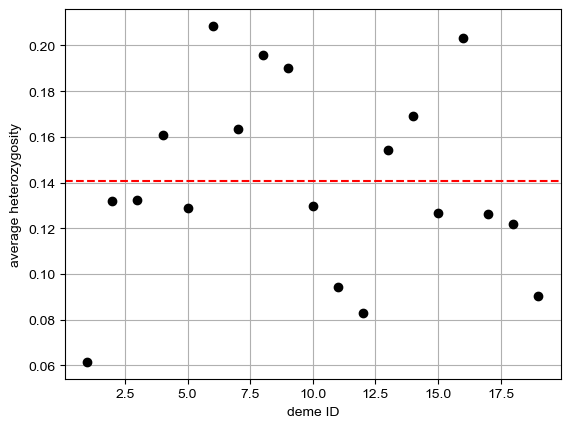

In [415]:
sample_idx = nx.get_node_attributes(warblr_graph, "sample_idx")
permuted_idx = query_node_attributes(warblr_graph, "permuted_idx")
observed_permuted_idx = permuted_idx[: warblr_graph.n_observed_nodes]

freqs = np.zeros_like(warblr_graph.frequencies)
for i, node_id in enumerate(observed_permuted_idx):
    s = sample_idx[node_id]

    # compute mean at each node
    freqs[i,:] = np.mean(warblr_graph.genotypes[s,:], axis=0)/2

het = 2*freqs*(1-freqs)

plt.plot(np.arange(1,warblr_graph.n_observed_nodes+1),het.mean(axis=1),'ko'); plt.axhline(het.mean(),color='red',linestyle='--'); plt.xlabel('deme ID'); plt.ylabel('average heterozygosity'); plt.grid()

constant-w/variance fit, converged in 145 iterations, train_loss=45007.608
lambda=0.001, alpha=1.9394, converged in 428 iterations, train_loss=31397.754


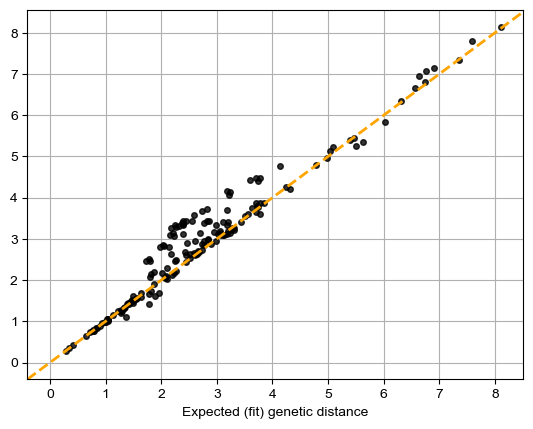

In [717]:
# lamb_grid = np.geomspace(1e-2, 1e2, 10)[::-1]
# cv10_err = run_cv_joint(warblr_graph, lamb_grid=lamb_grid, lamb_q_grid=lamb_grid, n_folds=10)
# plt.plot(lamb_grid,np.nanmean(cv10_err,axis=(0,1)),'k-o',label=r'$\lambda_w$'); plt.xlabel('values'); plt.ylabel('10-fold CV error'); plt.plot(lamb_grid,np.nanmean(cv10_err,axis=(0,2)),'-o',color='grey',label=r'$\lambda_q$'); plt.semilogx(); plt.legend(); 

smgraph.fit(lamb=0.001,optimize_q='n-dim',lamb_q=.001,alpha_q=0.01/np.mean(smgraph.s2))
obj = Joint_Objective(smgraph); obj.inv(); obj.grad(reg=False)
tril_idx = np.tril_indices(warblr_graph.n_observed_nodes, k=-1)
fit_cov, _, emp_cov = comp_mats(obj)
fit_dist = cov_to_dist(fit_cov)[tril_idx]
emp_dist = cov_to_dist(emp_cov)[tril_idx]

X = sm.add_constant(fit_dist)
mod = sm.OLS(emp_dist, X)
res = mod.fit()
muhat, betahat = res.params
plt.plot(fit_dist, emp_dist, 'o', color='k', alpha=0.8, markersize=4); plt.xlabel('Expected (fit) genetic distance'); 
# plt.plot(fit_dist, betahat*fit_dist+muhat, color='orange', ls='--', lw=1) 
plt.axline((0,0),slope=1,color='orange',ls='--',lw=2); plt.grid()
# plt.text(3.5, 0.5, r'$R^2 \approx {:.2f}$'.format(res.rsquared_adj), fontsize=15); plt.ylabel('Observed genetic distance')